In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tables as tb
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm, trange

In [3]:
from lmfit import Model, create_params
from lmfit.models import GaussianModel

mod = GaussianModel()


In [4]:
from scipy.special import erf


def damp_osci(x, x0, oa, rg, ro, phase, sigma, w):
    damp = oa * np.exp(-(x-x0)/rg)*np.cos((x-x0)/ro-phase)
    err_func = -0.5 * (erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w) ) + 0.5
    return damp * err_func

def exp_decay(x, Amplitude, x0, sigma, w, oa, rg, ro, phase):
    fit1 = Amplitude/2*np.exp(-(x-x0)/w + ((sigma/w)**2)/2)*(1-erf(-1/np.sqrt(2)*(x-x0)/sigma - sigma/w))
    osc = damp_osci(x, x0, oa, rg, ro, phase, sigma, w)
    return fit1 + osc

def gaussian(x, Amplitude, x0, sigma):
    return Amplitude * np.exp(-np.power(x - x0, 2.) / (2 * np.power(sigma, 2.)))

gmodel = Model(exp_decay)

In [5]:
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['Amplitude', 'x0', 'sigma', 'w', 'oa', 'rg', 'ro', 'phase']
independent variables: ['x']


In [6]:
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)
params

name,value,initial value,min,max,vary
Amplitude,0.06000000,0.06,-inf,inf,True
x0,0.00000000,0.0,-inf,inf,True
sigma,0.10000000,0.1,-inf,inf,True
w,0.10000000,0.1,-inf,inf,True
oa,0.00000000,0,-inf,inf,False
rg,10.0000000,10,-inf,inf,False
ro,10.0000000,10,-inf,inf,False
phase,0.00000000,0,-inf,inf,False


In [7]:
dataset_for_intensity = {}
dataset_for_peak_shift = {}

In [8]:
time_drifts = {}

In [9]:
plt.close('all')

# Jungfrau ROI1 signal

In [10]:
run_n = 70
exp_id = 'ue_240814_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]
problem_scans = []
for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]
   
    labels = dict(
        position_label = '',
        pump_event_label = 'event_info.RATE_HX_15HZ',
        #signal_label = 'pd:es:pd1:ch2',
        signal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum',
        # signal_label = 'detector:eh1:jungfrau2:ROI2_stat.sum',
        #norm_label = 'pd:es:pd1:ch
        #norm_label = 'qbpm:oh:qbpm2:sum',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        # norm_label = 'qbpm:eh1:qbpm2:sum',
        # norm_label = 'detector:eh1:jungfrau2:ROI2_stat.sum',
        
        #orm2_label = 'detector:eh1:jungfrau2:ROI7_stat.sum',
      # newsignal_label = 'detector:eh1:jungfrau2:ROI1_stat.sum'
    )
    
    positions = []
    signals_on = []
    signals_off = []
    ps_on = []
    ps_off = []
    sample_no_on = []
    sample_no_off = []
    norms_on = []
    norms_off = []
    signals_o_on = []
    signals_o_off = []
 
    for fname in tqdm(fnames[:], leave=True):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        elif 'phi_input' in df.columns.values:
            labels['position_label'] = 'phi_input'
        elif 'energy_input' in df.columns.values:
            labels['position_label'] = 'energy_input'
        elif 'dummy_input' in df.columns.values:
            labels['position_label'] = 'dummy_input'
        
        try:
            df_mini = df[labels.values()].dropna()
        except:
            psn = int(scan_dir.split('=')[1])
            problem_scans.append(psn)
            print('There was an error while reading scan=' + str(psn))
            continue
            
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        
        #bkg_mean = (df_mini[labels['bkg_label']] - df_mini[labels['signal_label']]) / (df_mini[labels['roi2_area_label']] - df_mini[labels['roi1_area_label']])
        roi_sum = (
            df_mini[[
                labels['signal_label'],
            ]].values
            ).sum(axis=1)
        
        norm = df_mini[labels['norm_label']] #- bkg_mean*df_mini[labels['roi3_area_label']]

        norm_mask = np.logical_and(
            norm > norm.mean() - norm.std()*2,
            norm < norm.mean() + norm.std()*2,
        )
        norm_on = norm[norm_mask][pump_event[norm_mask]]
        norm_off = norm[norm_mask][pump_event[norm_mask] != True]
          
        signal_on = roi_sum[norm_mask][pump_event[norm_mask]] #- bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_off = roi_sum[norm_mask][pump_event[norm_mask] != True] #- bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
               
        signal_ratio_on = signal_on / norm_on
        signal_ratio_off = signal_off / norm_off

        
        valid_on = np.logical_and(
            signal_ratio_on<signal_ratio_on.median() + signal_ratio_on.std()*.3, 
            signal_ratio_on>signal_ratio_on.median() - signal_ratio_on.std()*.3
            )
        valid_off = np.logical_and(
            signal_ratio_off<signal_ratio_off.median() + signal_ratio_off.std()*.3, 
            signal_ratio_off>signal_ratio_off.median() - signal_ratio_off.std()*.3
            )

        try:
            p_on = np.polyfit(norm_off, signal_off, 1)
            p_off = np.polyfit(norm_on, signal_on, 1)
        except:
            print('There was an error while reading p_on or p_off, ' + scan_dir)
            continue
        
    
        signal_norm_on = np.average(
            signal_on[valid_on] / norm_on[valid_on],
            weights = norm_on[valid_on]
            )
        signal_norm_off = np.average(
            signal_off[valid_off] / norm_off[valid_off],
            weights = norm_off[valid_off]
            )

        positions.append(position)
        signals_on.append(signal_norm_on)
        signals_off.append(signal_norm_off)
        #ps_on.append(p_on)
        #ps_off.append(p_off)
        sample_no_on.append(valid_on.size)
        sample_no_off.append(valid_off.size)

        signals_o_on.append(np.average(signal_on[valid_on]))
        signals_o_off.append(np.average(signal_off[valid_off]))
        norms_on.append(np.average(norm_on[valid_on]))
        norms_off.append(np.average(norm_off[valid_off]))
        
        
    positions = np.array(positions)
    signals_on = np.array(signals_on)
    signals_off = np.array(signals_off)
    signals_diff = (signals_on - signals_off)/signals_off
    #ps_on = np.array(ps_on)
    #ps_off = np.array(ps_off)
    signals_o_on = np.array(signals_o_on)
    signals_o_off = np.array(signals_o_off)
    norms_on = np.array(norms_on)
    norms_off = np.array(norms_off)
    
    dataset_for_intensity[(run_n, scan_n)] = \
        {
            "labels": labels,
            "positions": positions,
            "signals_on": signals_on,
            "signals_off": signals_off,
            "signals_diff": signals_diff,
            "ps_on": ps_on,
            "ps_off": ps_off, 
            "sample_size_on": np.array(sample_no_on),
            "sample_size_off": np.array(sample_no_off),
        }


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

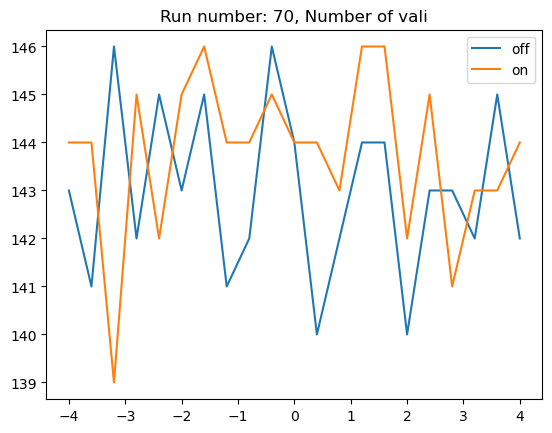

In [11]:
plt.figure()
plt.title(f"Run number: {run_n:}, Number of vali")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["sample_size_off"], label = 'off')
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["sample_size_on"], label = 'on')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (150,) and (142,)

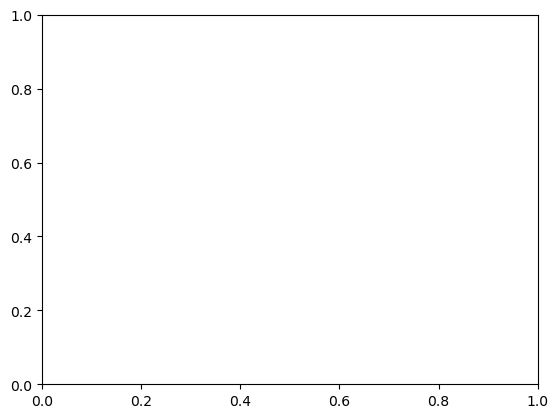

In [16]:
plt.figure(1)
plt.plot(norm_off, signal_off, '.')
plt.plot(norm_on, signal_on, '.')
plt.plot([0, norm_off.max()], signal_norm_off * np.array([0, norm_off.max()]))
plt.plot([0, norm_on.max()], signal_norm_on * np.array([0, norm_on.max()]))
plt.legend(['laser_off', 'laser_on']);
# plt.ylim([-500,4000])
#plt.xlabel('I_qbpm1');
#plt.ylabel('I_signal');
plt.title('correlation plot');
plt.xlabel('I_0')
plt.ylabel('Integrated Jungfrau')
plt.show()

#np.savetxt(f"run ={run_n}", np.array([positions, newsignals_diff]), delimiter=",")
#np.savetxt(f"run ={run_n}", np.array([positions,  signals_off, signals_on]), delimiter=",")

KeyError: (51, 1)

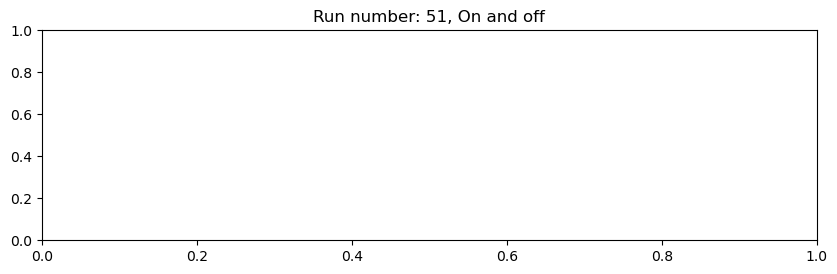

In [17]:

plt.figure(20,figsize=(10,6))
plt.subplot(2, 1, 1)
plt.title(f"Run number: {run_n:}, On and off")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_off"], '.-')
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_on"], '.-')
#plt.xlim([8,15])
plt.legend(['Loff', 'Lon']);plt.grid();plt.ylabel('Intensity');plt.xlabel('delay')
plt.subplot(2, 1, 2)
plt.title(f"Run number: {run_n:}, Diff. ratio")
plt.plot(dataset_for_intensity[(run_n, scan_n)]["positions"], dataset_for_intensity[(run_n, scan_n)]["signals_diff"], '.-')
plt.grid();plt.ylabel('Intensity');plt.xlabel('delay')

plt.show()

KeyError: (66, 1)

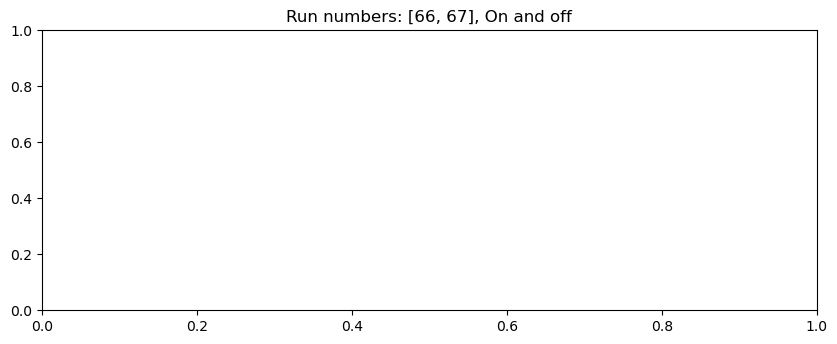

In [74]:
run_ns = [66, 67]
#run_ns = [56, 57, 58, 59, 60]
#run_ns = range(29, 51)

plt.figure(20,figsize=(10,8))
plt.subplot(2, 1, 1)
plt.title(f"Run numbers: {run_ns:}, On and off")
for run_n in run_ns:
    plt.plot(
        dataset_for_intensity[(run_n, scan_n)]["positions"], 
        dataset_for_intensity[(run_n, scan_n)]["signals_off"], 
        '.-',
        label = f'Run #{run_n:}, Loff'
    )
    plt.plot(
        dataset_for_intensity[(run_n, scan_n)]["positions"], 
        dataset_for_intensity[(run_n, scan_n)]["signals_on"], 
        '.-',
        label = f'Run #{run_n:}, Lon'
    )
#plt.xlim([8,15])
plt.grid()
plt.ylabel('Intensity')
plt.xlabel('delay')
plt.legend()
plt.subplot(2, 1, 2)
plt.title(f"Run numbers: {run_ns:}, Diff. ratio")
for run_n in run_ns:
    plt.plot(
        dataset_for_intensity[(run_n, scan_n)]["positions"], 
        dataset_for_intensity[(run_n, scan_n)]["signals_diff"], 
        '.-',
        label = f'Run #{run_n:}'
    )
plt.grid()
plt.ylabel('Intensity')
plt.xlabel('delay')
plt.legend()
plt.show()

In [19]:
plt.figure(21)
plt.plot(
    dataset_for_intensity[(run_n, scan_n)]["positions"], 
    np.mean(
        [dataset_for_intensity[(run_n, scan_n)]["signals_diff"] for run_n in run_ns], 
        axis=0, 
    ),
    
    '.-',
    label = f'Run #{run_n:}'
)
plt.grid()
plt.ylabel('Intensity')
plt.xlabel('delay')
plt.title(f"Run numbers: {run_ns:}, Averaged Diff. ratio")

plt.show()

KeyError: (62, 1)

<Figure size 640x480 with 0 Axes>

# Center of Mass

In [23]:
run_n = 154

exp_id = 'ue_240821_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_15HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        #signal_x_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        #signal_y_label = 'detector:eh1:jungfrau2:ROI3_stat.center_of_mass.y',
        #roi1_area_label = 'detector:eh1:jungfrau2:ROI2_stat.area',
        norm_label = 'qbpm:eh1:qbpm1:sum',
        #norm_label = 'qbpm:oh:qbpm2:sum',
    )

    positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'th_input' in df.columns.values:
            labels['position_label'] = 'th_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']] ;        COMy = df_mini[labels['signal_y_label']] #+ 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
        signal_x_on = COMx[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] # - bkg_mean[pump_event] * df_mini[labels['roi1_area_label']][pump_event]
        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(
            signal_x_on ,#/ norm_on,
            weights = norm_on        )
        signal_x_norm_off = np.average(
            signal_x_off ,#/ norm_off,
            weights = norm_off        )
        signal_y_norm_on = np.average(
            signal_y_on ,#/ norm_on,
            weights = norm_on        )
        signal_y_norm_off = np.average(
            signal_y_off ,#/ norm_off,
            weights = norm_off        )

        positions.append(position)
        signals_x_on.append(signal_x_norm_on);        signals_x_off.append(signal_x_norm_off);        signals_y_on.append(signal_y_norm_on);        signals_y_off.append(signal_y_norm_off)

    positions = np.array(positions);    signals_x_on = np.array(signals_x_on);    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on);    signals_y_off = np.array(signals_y_off)
    signals_x_diff = (signals_x_off - signals_x_on);    signals_y_diff = (signals_y_off - signals_y_on)

    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,        "positions": positions,        "signals_x_on": signals_x_on,        "signals_x_off": signals_x_off,        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,        "signals_y_off": signals_y_off,        "signals_y_diff": signals_y_diff,
    }
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

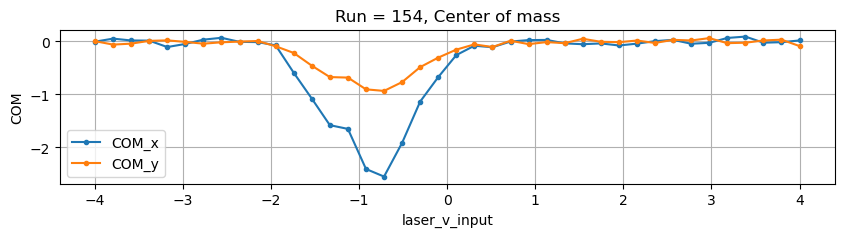

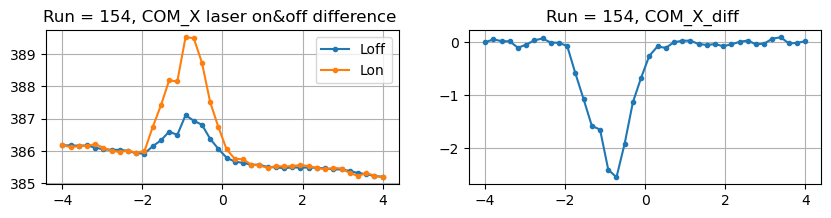

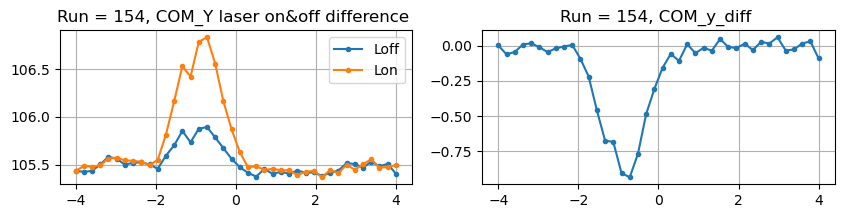

In [24]:
plt.figure(6,figsize=(10,2))
for scan_n in scan_numbers:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.xlabel(labels['position_label'])
plt.ylabel('COM')
plt.legend(['COM_x','COM_y'])
plt.title(f'Run = {run_n}, Center of mass')
plt.grid()

plt.figure(7,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()

plt.figure(8,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_y_diff ')
plt.grid()

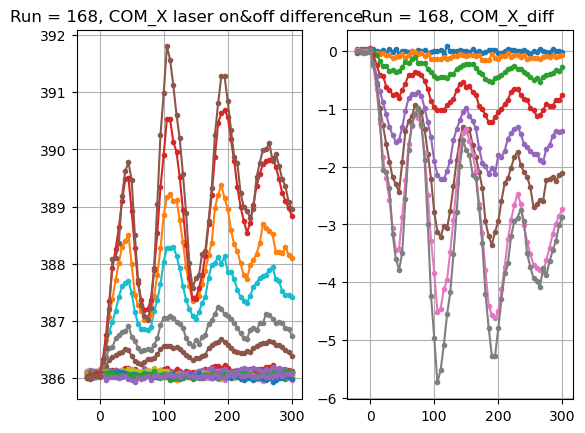

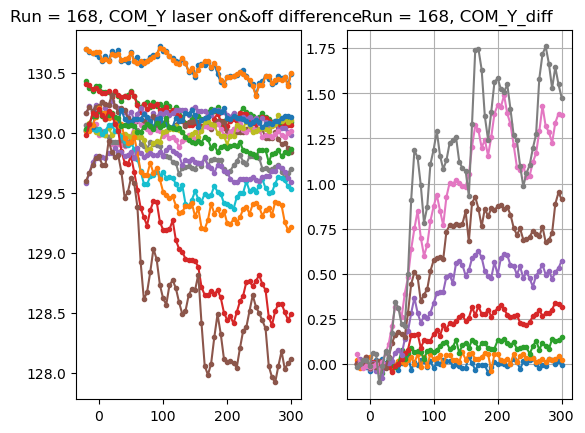

In [94]:
run_ns = [161, 162, 163, 164, 165, 166, 167, 168]

plt.figure(7)
plt.subplot(1, 2, 1)
for run_n in run_ns:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"], '.-')
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"], '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')
plt.grid()
plt.figure(7)
plt.subplot(1, 2, 2)
for run_n in run_ns:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()
plt.show()

plt.figure(8)
plt.subplot(1, 2, 1)
for run_n in run_ns:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')

plt.figure(8)
plt.subplot(1, 2, 2)
for run_n in run_ns:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.title(f'Run = {run_n}, COM_Y_diff ')
plt.grid()
plt.show()

# laser power check

In [ ]:
plt.figure(82)

for i in range(37,48):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([1,2,3,4,5,6,8,9,10,15,20])
plt.grid()

plt.show()

plt.figure(83)
for i in range(37,48):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([1,2,3,4,5,6,8,9,10,15,20])
plt.grid()
plt.show()

In [ ]:
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')

In [ ]:
xdfdata=[];ydfdata=[]
ii=0
jj=11
for i in range(37,48):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([1,2,3,4,5,6,8,9,10,15,20],xdfdata,'.-')
plt.plot([1,2,3,4,5,6,8,9,10,15,20],ydfdata,'.-')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('delay(ps)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])

In [ ]:
plt.figure(82)
for i in range(36,48):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    plt.axhline(y=0, color='k', linestyle='-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
#plt.axis([-1, 15, -2, 0.2])
plt.show()

In [ ]:
plt.figure(82,figsize=(15,5))

plt.subplot(1,2,1)
for i in range(79,93):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([15,16,17,18,19,20,15,14,13,12,11,10,8,6])
plt.grid()

plt.xlim([-20,200]);plt.ylim([-10,3])
# plt.show()

plt.subplot(1,2,2)
for i in range(79,93):
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_Y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([15,16,17,18,19,20,15,14,13,12,11,10,8,6])
plt.grid()

plt.xlim([-20,200]);plt.ylim([-10,3])
plt.show()

In [ ]:
plt.figure(82)

for i in [47,79,85]:
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_X_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([47,79,85])
plt.grid()

plt.show()

for i in [47,79,85]:
    run_n = i
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
    # plt.axhline(y=0, color='k', linestyle='-')
plt.title(f' COM_Y_diff ')
plt.ylabel('Peak shift (pixels)')
plt.xlabel('Delay (ps)')
plt.legend([47,79,85])
plt.grid()

plt.show()


In [ ]:
plt.figure(82,figsize=(15,5))
plt.subplot(1,3,1)
xdfdata=[];ydfdata=[]
ii=0
jj=8
for i in range(79,93):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])
xdfdata=[];ydfdata=[]


plt.subplot(1,3,2)
xdfdata=[];ydfdata=[]
ii=0
jj=10
for i in range(79,93):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])
xdfdata=[];ydfdata=[]

plt.subplot(1,3,3)
ii=0
jj=12
for i in range(79,93):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10,8,6],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])

In [ ]:
xdfdata=[];ydfdata=[]
ii=0
jj=9
for i in range(79,91):
    run_n=i
    xdfdata = np.append(xdfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][jj])
    ydfdata = np.append(ydfdata,dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"][jj])
    ii+=1
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10],xdfdata,'o')
plt.plot([15,16,17,18,19,20,15,14,13,12,11,10],ydfdata,'o')
delay=dataset_for_peak_shift[(run_n, scan_n)]["positions"][jj]
plt.title(f'delay at {delay}ps')
plt.xlabel('laser power (%)');plt.ylabel('pixel difference')
plt.grid()
plt.legend(['xdiff','ydiff'])
plt.ylim([-8,2])

# spatial overlap check

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Text(0.5, 1.0, 'runNum : 154')

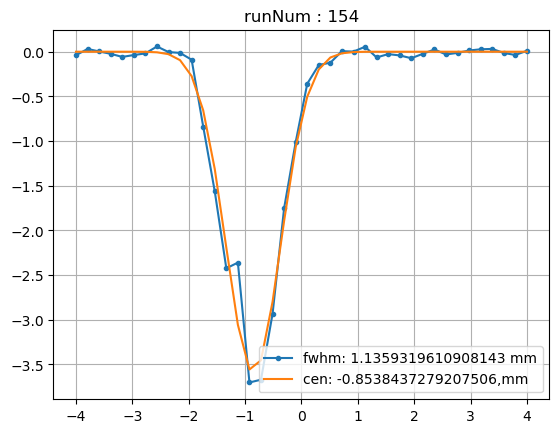

In [28]:
run_n = 154

exp_id = 'ue_240821_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]

for scan_dir in tqdm(scan_dirs):
    scan_n = int(scan_dir.replace('scan=', ''))
    fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]

    labels = dict(
        position_label = 'laser_h_input',
        pump_event_label = 'event_info.RATE_HX_30HZ',
        signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
        signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
        norm_label = 'qbpm:oh:qbpm2:sum',
        # norm_label = 'qbpm:eh1:qbpm1:sum',        
    )

    positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
    for fname in tqdm(fnames, leave=False):
        df = pd.read_hdf(fname)
        if 'delay_input' in df.columns.values:
            labels['position_label'] = 'delay_input'
        elif 'laser_v_input' in df.columns.values:
            labels['position_label'] = 'laser_v_input'
        elif 'laser_h_input' in df.columns.values:
            labels['position_label'] = 'laser_h_input'
        elif 'laser_fluence_percent_input' in df.columns.values:
            labels['position_label'] = 'laser_fluence_percent_input'
        
        df_mini = df[labels.values()].dropna()
        position = df_mini[labels['position_label']].median()
        pump_event = df_mini[labels['pump_event_label']] == True
        COMx = df_mini[labels['signal_x_label']] ;        COMy = df_mini[labels['signal_y_label']] #+ 1000
        norm = df_mini[labels['norm_label']]

        norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
        signal_x_on = COMx[pump_event] ;        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
        signal_y_on = COMy[pump_event] ;        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]

        signal_x_norm_on = np.average(signal_x_on ,#/ norm_on,
            weights = norm_on        )
        signal_x_norm_off = np.average(signal_x_off ,#/ norm_off,
            weights = norm_off        )
        signal_y_norm_on = np.average(signal_y_on ,#/ norm_on,
            weights = norm_on        )
        signal_y_norm_off = np.average(signal_y_off ,#/ norm_off,
            weights = norm_off        )

        positions.append(position);        signals_x_on.append(signal_x_norm_on);        signals_x_off.append(signal_x_norm_off);        signals_y_on.append(signal_y_norm_on);        signals_y_off.append(signal_y_norm_off)
    positions = np.array(positions);    signals_x_on = np.array(signals_x_on);    signals_x_off = np.array(signals_x_off)
    signals_y_on = np.array(signals_y_on);    signals_y_off = np.array(signals_y_off)
    signals_x_diff = (signals_x_off - signals_x_on);    signals_y_diff = (signals_y_off - signals_y_on)
    dataset_for_peak_shift[(run_n, scan_n)] = {
        "labels": labels,        "positions": positions,        "signals_x_on": signals_x_on,        "signals_x_off": signals_x_off,        "signals_x_diff": signals_x_diff,
        "signals_y_on": signals_y_on,        "signals_y_off": signals_y_off,        "signals_y_diff": signals_y_diff,    }

xdata=[];ydata=[]
plt.figure()
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, '.-')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit)
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
plt.title(f'runNum : {run_n}')
# plt.figure(28)
# run_n = 28
# xdata2=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
# ydata2= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]

# plt.plot(xdata,ydata, '.-')

(40,)
(40,)


Text(0.5, 1.0, 'compare')

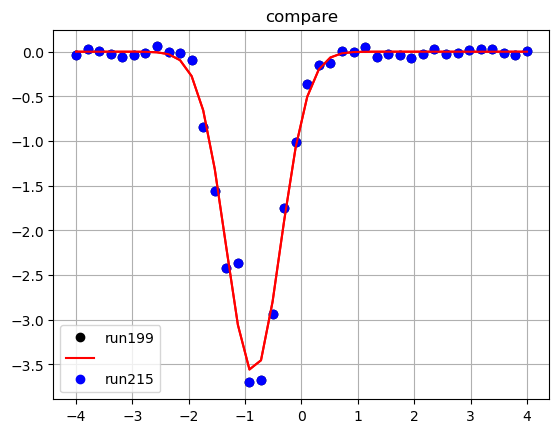

In [36]:
xdata=[];ydata=[]
run_n = 154
plt.figure()
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'ko')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
# plt.title(f'runNum : {run_n}')
# plt.plot(11.3739,-3,'.')

run_n = 154
xdata=[];ydata=[]

xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]

plt.plot(xdata,ydata, 'bo')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
# plt.title(f'runNum : {run_n}')
plt.grid()
plt.legend(['run199','','run215'])
plt.title('compare')

In [ ]:
xdata=[];ydata=[]
run_n = 200
plt.figure()
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'ko')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
plt.title(f'runNum : {run_n}')
# plt.plot(11.3739,-3,'.')

run_n = 216
xdata=[];ydata=[]

xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata= dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
plt.plot(xdata,ydata, 'bo')
pars=mod.guess(ydata,x=xdata)
yf=mod.fit(ydata,pars,x=xdata)
plt.plot(xdata,yf.best_fit,'r')
plt.grid()
fitfwhm=yf.params['fwhm'].value
fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter},mm'])
plt.title(f'runNum : {run_n}')
plt.grid()
plt.legend(['run200','','run216'])

In [ ]:
run_n=224
xdata=[];ydata=[]
params = gmodel.make_params(
    Amplitude=dict(value=0.06), 
    x0=dict(value=0.0), 
    sigma=dict(value=0.1), 
    w=dict(value=0.1), 
    oa=dict(value=0, vary=False),
    rg=dict(value=10, vary=False), 
    ro=dict(value=10, vary=False), 
    phase=dict(value=0, vary=False)
)
params
plt.figure()
gmodel = Model(exp_decay)
xdata=dataset_for_peak_shift[(run_n, scan_n)]["positions"]
ydata=dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"]

plt.plot(xdata,ydata, '.-')
yf=gmodel.fit(ydata,params,x=xdata)
plt.plot(xdata,yf.best_fit)
plt.grid()
# fitfwhm=yf.params['fwhm'].value
x0=yf.params['x0'].value
plt.legend([f'timezero: {x0}'])
# fitcenter=yf.params['center'].value
# plt.legend([f'fwhm: {fitfwhm} mm', f'cen: {fitcenter}'])

plt.title(f'runNum : {run_n}')
# plt.plot(2.2657,-3,'.')

In [ ]:
yf.params['x0']

In [ ]:
params

# ON Off Compare
# Manualy made new code

In [49]:
def add_to_dataset_for_peak_shift(run_n):
    exp_id = 'ue_240821_FXS'
    run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'
    scan_dirs = [scan_dir for scan_dir in sorted(os.listdir(run_dir)) if scan_dir.startswith('scan=')]
    scan_numbers = [int(scan_dir.replace('scan=', '')) for scan_dir in scan_dirs]
    
    for scan_dir in tqdm(scan_dirs):
        scan_n = int(scan_dir.replace('scan=', ''))
        fnames = [os.path.join(run_dir, scan_dir, fname) for fname in sorted(os.listdir(os.path.join(run_dir, scan_dir)))]
    
        labels = dict(
            position_label = 'laser_h_input',
            pump_event_label = 'event_info.RATE_HX_30HZ',
            signal_x_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.x',
            signal_y_label = 'detector:eh1:jungfrau2:ROI1_stat.center_of_mass.y',
            norm_label = 'qbpm:oh:qbpm2:sum',
            # norm_label = 'qbpm:eh1:qbpm1:sum',        
        )
    
        positions = [];    signals_x_on = [];    signals_x_off = [];    signals_y_on = [];    signals_y_off = [];
        for fname in tqdm(fnames, leave=False):
            df = pd.read_hdf(fname)
            if 'delay_input' in df.columns.values:
                labels['position_label'] = 'delay_input'
            elif 'laser_v_input' in df.columns.values:
                labels['position_label'] = 'laser_v_input'
            elif 'laser_h_input' in df.columns.values:
                labels['position_label'] = 'laser_h_input'
            elif 'laser_fluence_percent_input' in df.columns.values:
                labels['position_label'] = 'laser_fluence_percent_input'
            
            df_mini = df[labels.values()].dropna()
            position = df_mini[labels['position_label']].median()
            pump_event = df_mini[labels['pump_event_label']] == True
            COMx = df_mini[labels['signal_x_label']] ;        COMy = df_mini[labels['signal_y_label']] #+ 1000
            norm = df_mini[labels['norm_label']]
    
            norm_on = norm[pump_event] ;        norm_off = norm[pump_event != True]
            signal_x_on = COMx[pump_event] ;        signal_x_off = COMx[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
            signal_y_on = COMy[pump_event] ;        signal_y_off = COMy[pump_event != True] # - bkg_mean[pump_event != True] * df_mini[labels['roi1_area_label']][pump_event !=True]
    
            signal_x_norm_on = np.average(signal_x_on ,#/ norm_on,
                weights = norm_on        )
            signal_x_norm_off = np.average(signal_x_off ,#/ norm_off,
                weights = norm_off        )
            signal_y_norm_on = np.average(signal_y_on ,#/ norm_on,
                weights = norm_on        )
            signal_y_norm_off = np.average(signal_y_off ,#/ norm_off,
                weights = norm_off        )
    
            positions.append(position);        signals_x_on.append(signal_x_norm_on);        signals_x_off.append(signal_x_norm_off);        signals_y_on.append(signal_y_norm_on);        signals_y_off.append(signal_y_norm_off)
        positions = np.array(positions);    signals_x_on = np.array(signals_x_on);    signals_x_off = np.array(signals_x_off)
        signals_y_on = np.array(signals_y_on);    signals_y_off = np.array(signals_y_off)
        signals_x_diff = (signals_x_off - signals_x_on);    signals_y_diff = (signals_y_off - signals_y_on)
        dataset_for_peak_shift[(run_n, scan_n)] = {
            "labels": labels,        "positions": positions,        "signals_x_on": signals_x_on,        "signals_x_off": signals_x_off,        "signals_x_diff": signals_x_diff,
            "signals_y_on": signals_y_on,        "signals_y_off": signals_y_off,        "signals_y_diff": signals_y_diff,    }


In [194]:
runs = [207,208,209]
for run_ in tqdm(runs, leave=False):
    add_to_dataset_for_peak_shift(run_)

import datetime

runs = [207,208,209]

timestr_0 = '202408216:57:45'
dt_0 = datetime.datetime.strptime(timestr_0, '%Y%m%d%H:%M:%S')

dts = []
for run in runs:

    log_file = f'/xfel/ffs/dat/ue_240821_FXS/log/type=measurement/run={run:03}/scan=001/p0001.h5.log'
    
    with open(log_file) as f:
        line = f.readline()
        times = line.split('  ')[0]
        
        a = times.split()
        timestr = '20' + a[1] + a[2]
        dt = datetime.datetime.strptime(timestr, '%Y%m%d%H:%M:%S')
        dts.append(dt)
    
# dts = np.array(dts)
# dts = dts - dt_0


for run_n, dt in zip(runs, dts):
    
    scan_n = 1
    positions = dataset_for_peak_shift[(run_n, scan_n)]["positions"]

    sig_xdiff = dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]
    sig_ydiff = dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"]

    def get_fitting(xdata, ydata):
        pars = mod.guess(ydata,x=xdata)
        yf = mod.fit(ydata,pars,x=xdata)
        return {
            'center': yf.params['center'].value,
            'fwhm': yf.params['fwhm'].value,
            'array': yf.best_fit
        }
    
    x_diff_fitting = get_fitting(positions, sig_xdiff)
    y_diff_fitting = get_fitting(positions, sig_ydiff)
    
    print(run_n, "--",x_diff_fitting['center'], 
          x_diff_fitting['fwhm'], 
          y_diff_fitting['center'], 
          y_diff_fitting['fwhm'],
         dt.strftime('%y%m%d'),
          dt.strftime('%H:%M:%S'),
         (dt - dt_0).total_seconds())


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

207 -- -0.19519786620904014 0.8053032393458553 -0.1003047244626272 0.9330664920556915 240824 15:30:51 289986.0
208 -- -0.23584109192079578 0.8082325224166081 -0.2629523315308144 0.14022075128977132 240824 15:33:25 290140.0
209 -- 8.075435644660306 1.8543834778310284 -1.5306090001995412 1.6024235943586087 240824 15:36:28 290323.0


TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=2

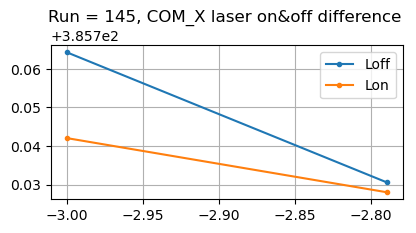

In [73]:
#### run_n = 154
scan_n = 1
positions = dataset_for_peak_shift[(run_n, scan_n)]["positions"]

sig_xoff = dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"]
sig_xon = dataset_for_peak_shift[(run_n, scan_n)]["signals_x_on"]
sig_xoff = dataset_for_peak_shift[(run_n, scan_n)]["signals_x_off"]
sig_xdiff = dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"]

sig_yoff = dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"]
sig_yon = dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"]
sig_yoff = dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"]
sig_ydiff = dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"]

def get_fitting(xdata, ydata):
    pars = mod.guess(ydata,x=xdata)
    yf = mod.fit(ydata,pars,x=xdata)
    return {
        'center': yf.params['center'].value,
        'fwhm': yf.params['fwhm'].value,
        'array': yf.best_fit
    }

plt.figure(7,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(positions, sig_xoff, '.-')
plt.plot(positions, sig_xon, '.-')
plt.title(f'Run = {run_n}, COM_X laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

x_diff_fitting = get_fitting(positions, sig_xdiff)
print(f'x_diff_center {x_diff_fitting["center"]}')
print(f'x_diff_fwhm {x_diff_fitting["fwhm"]}')
plt.subplot(1, 2, 2)
plt.plot(positions, sig_xdiff, '.-')
plt.plot(positions, x_diff_fitting['array'], 'black')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()

plt.figure(8,figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(positions, dataset_for_peak_shift[(run_n, scan_n)]["signals_y_off"], '.-')
plt.plot(positions, dataset_for_peak_shift[(run_n, scan_n)]["signals_y_on"], '.-')
plt.title(f'Run = {run_n}, COM_Y laser on&off difference ')
plt.legend(['Loff', 'Lon'])
plt.grid()

y_diff_fitting = get_fitting(positions, sig_ydiff)
print(f'y_diff_center {y_diff_fitting["center"]}')
print(f'y_diff_fwhm {y_diff_fitting["fwhm"]}')
plt.subplot(1, 2, 2)
plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_y_diff"], '.-')
plt.plot(positions, get_fitted_array(positions, sig_ydiff), 'black')
plt.title(f'Run = {run_n}, COM_y_diff ')
plt.grid()

In [106]:
run_dict = {
    161: 1, 
    162: 3, 
    163: 5, 
    164: 7, 
    165: 9,
    166: 11, 
    167: 13, 
    168: 15
}

xs = [45, 100, 190, 265]

x_powers_dict = {x: {
    'powers': [],
    'values': []
} for x in xs}

for x in xs:
    for run_n, power in run_dict.items():
        index = np.where(dataset_for_peak_shift[(run_n, scan_n)]["positions"] == x)
        value = dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"][index]

        x_powers_dict[x]['powers'].append(power)
        x_powers_dict[x]['values'].append(value)
print(index)

(array([57]),)


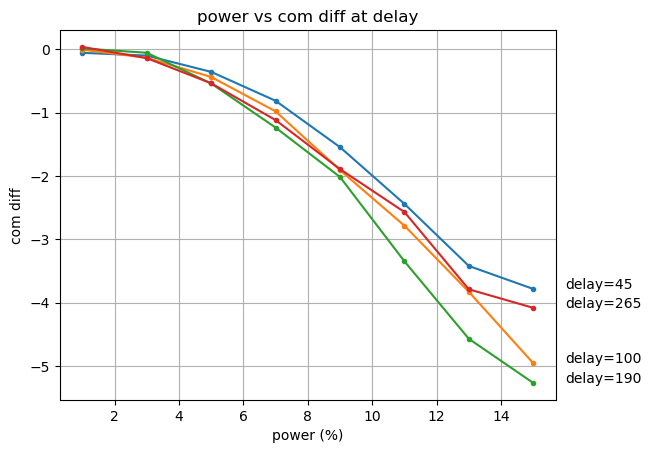

In [117]:
fig, ax = plt.subplots(1, 1)
for x, power_values in x_powers_dict.items():

    ax.plot(power_values['powers'], power_values['values'], '.-')
    ax.text(power_values['powers'][-1] + 1, power_values['values'][-1], f'delay={x}')
    ax.set_xlabel('power (%)')
    ax.set_ylabel('com diff')
ax.set_title(f'power vs com diff at delay')
ax.grid()

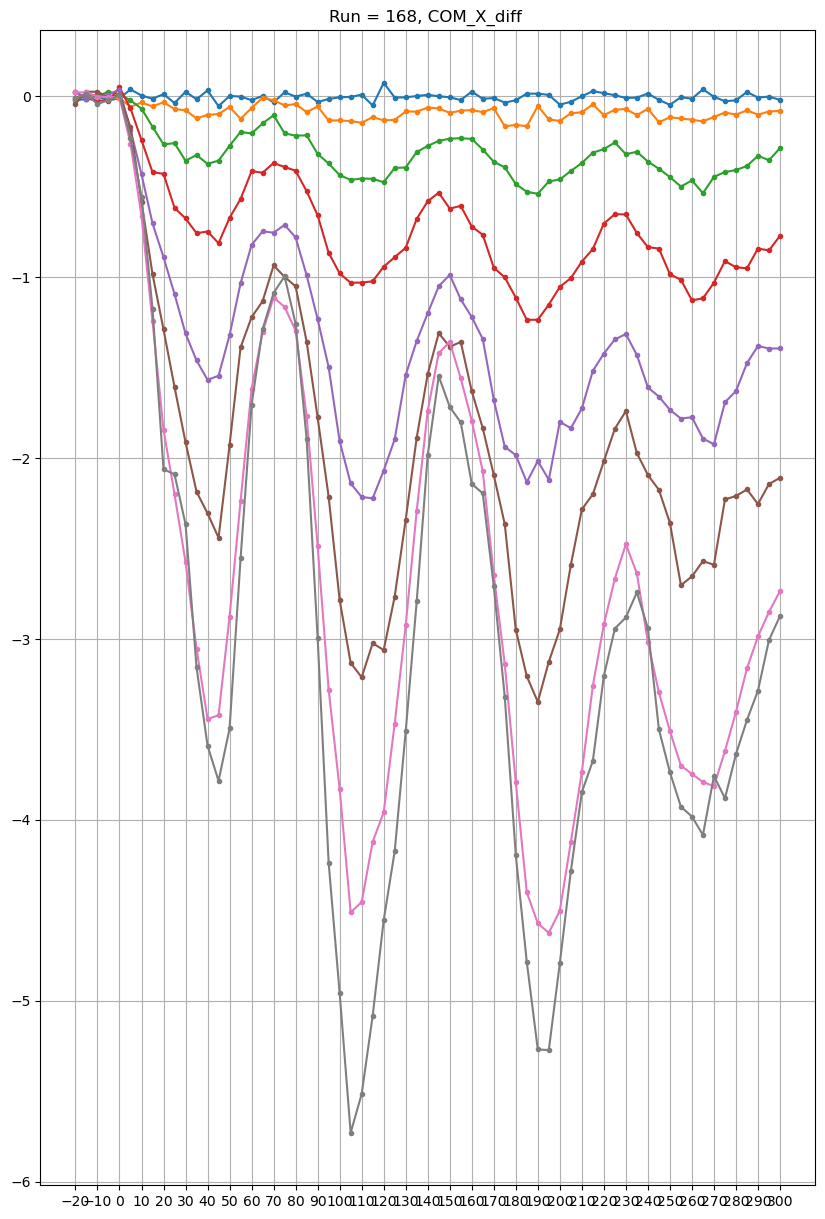

In [99]:
plt.figure(7,figsize=(10,15))
plt.subplot(1, 1, 1)

for run_n in run_ns:
    plt.plot(dataset_for_peak_shift[(run_n, scan_n)]["positions"], dataset_for_peak_shift[(run_n, scan_n)]["signals_x_diff"], '.-')
plt.title(f'Run = {run_n}, COM_X_diff ')
plt.grid()
plt.xticks(dataset_for_peak_shift[(run_n, scan_n)]["positions"][::2]);

In [146]:
import pandas as pd

laser_hv_file = 'laser_hv.csv'
df = pd.read_csv(laser_hv_file)
numcolumns = ['# run number', 'x center', 'x fwhm', 'y center', 'y fwhm', 'delta seconds']
df[numcolumns] = df[numcolumns].apply(pd.to_numeric)
df.head()

,# run number,oriantation(v/h),x center,x fwhm,y center,y fwhm,date,time,delta seconds
0,11,h,0.165001,0.840836,1.544793,5.697858,240821,6:57:45,0
1,12,v,-0.658548,1.371594,1.677107,0.592799,240821,7:00:27,162
2,40,v,-0.580260,0.105443,-0.611050,0.090932,240821,11:40:46,16981
3,41,v,-3.516926,0.114143,2.642809,2.653227,240821,11:45:03,17238
4,42,v,-0.238719,0.155633,-0.231873,0.067810,240821,11:49:16,17491


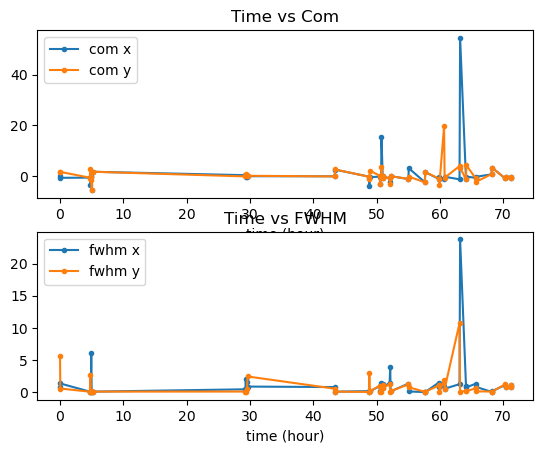

In [158]:
fig, ax = plt.subplots(2, 1)

# df = df[df['delta seconds'] > 150000]

hours = df['delta seconds'] / 60 / 60
com_x = df['x center']
com_y = df['y center']
fwhm_x = df['x fwhm']
fwhm_y = df['y fwhm']

ax[0].set_title('Time vs Com')
ax[0].plot(hours, com_x, '.-', label='com x')
ax[0].plot(hours, com_y, '.-', label='com y')
ax[0].set_xlabel('time (hour)')
ax[0].legend()

ax[1].set_title('Time vs FWHM')
ax[1].plot(hours, fwhm_x, '.-', label='fwhm x')
ax[1].plot(hours, fwhm_y, '.-', label='fwhm y')
ax[1].set_xlabel('time (hour)')
ax[1].legend()
# ax.set_ylim(None, 10)

In [126]:
for run in df['# run number']:
    print(run, end=', ')

11, 12, 40, 41, 42, 43, 44, 45, 66, 67, 68, 69, 72, 73, 76, 77, 78, 82, 83, 86, 87, 88, 89, 94, 95, 96, 107, 108, 112, 113, 123, 124, 125, 126, 135, 136, 139, 140, 146, 147, 150, 151, 154, 155, 159, 160, 

In [ ]:
exp_id = 'ue_240821_FXS'
run_dir = f'/xfel/ffs/dat/{exp_id}/raw_data/h5/type=measurement/run={run_n:03}'

2024-08-24 09:23:29
2024-08-24 09:31:36
267944.0
268431.0
